 # Application of machine learning approaches towards the prediction of gene expression levels in *Streptococcus thermophilus*
Prediction of gene expression levels from promoter sequences

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import xgboost as xgboost
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import pickle
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

## Data arrangement and pre-processing

In [8]:
# Load the promoter sequences

filtered_promoter_file_path = "../promoter_extraction/filtered_promoters_100_bp.fasta"

def read_filtered_promoters(file_path):
    """
    Reads the filtered promoters from a file and returns each line
    :param file_path: path to the file with the filtered promoters
    :return: lines of the file
    """
    with open(file_path, "r") as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = [line.split("\t") for line in lines]
    lines = [line[0] for line in lines]
    return lines

# read_filtered_promoters(filtered_promoter_file_path)

In [9]:
# Create a dataframe with the promoter sequences

def create_filtered_promoters_df(filename):
    """
    Creates a dataframe with the filtered promoters
    :param filename: name of the file with the filtered promoters
    :return: dataframe with the filtered promoters indicating if they correspond to the reverse complement of the gene, the locus tag of the gene and its coordiantes.
    """
    lines = read_filtered_promoters(filename)
    df = pd.DataFrame(lines)
    df.columns = ['Promoter Type']
    df[['Promoter Type', 'Locus Tag', "Location Coordinates", "Promoter Sequence"]] = df['Promoter Type'].str.split(';', 4, expand=True)
    return df

filtered_promoter_df = create_filtered_promoters_df(filtered_promoter_file_path)
filtered_promoter_df
# create_filtered_promoters_df(filtered_promoter_file_path)

,Promoter Type,Locus Tag,Location Coordinates,Promoter Sequence
0,Promoter reverse complement,T303_00015,[2011:2347](-),AAGTCTCAACAAGTAAGTCTCTAAGCCCCTAACCATAAGGTTTTGG...
1,Promoter reverse complement,T303_00025,[4153:5353](-),AAAAAAATAGTTGACATATGAATAAATATTCAATATAATTTATCTC...
2,Promoter reverse complement,T303_00030,[6254:7709](-),AGGATTGATACTTATAAGCTTATGCTTAAGCTTGGGGAGAGCCTTC...
3,Promoter reverse complement,T303_00035,[7890:8945](-),TCATTGTAAGAGTAGTAAAAACCTATCTTCGGATAGGTTTTTTTAA...
4,Promoter,T303_00050,[10422:10776](+),TACCTTATCTATTATACAAAAATTCTTTTTAGATGCAAGAAATTCT...
...,...,...,...,...
803,Promoter,T303_09885,[1840783:1840921](+),AAAACTTAAATATACAATACAAGAGATAAGTACACAATAAAAACTC...
804,Promoter reverse complement,T303_09890,[1841032:1842175](-),TGACAATTCTTATAAAATTTGATACACTAATGCAGTTGTGGATAAT...
805,Promoter reverse complement,T303_09895,[1842429:1842711](-),TGGGAAATACAAAGCAAGTATTGGTCAAATCTTCCTATTATTATGT...
806,Promoter reverse complement,T303_09900,[1843080:1843215](-),ACAAGAGCATGCTATTACTATAAAATAATATGGTATGTTTAGTAAC...


In [10]:
# Create dataframe with the gene expression values

expression_data = pd.read_excel("gene_expression_dataset.XLSX", sheet_name='log2CPM_AllConditions')
expression_df = pd.DataFrame(expression_data, columns=["Locus Tag", "Gene Expression Values for Condition 1 (Mean)"])
expression_df.set_index("Locus Tag", inplace=True)
expression_df

,Gene Expression Values for Condition 1 (Mean)
Locus Tag,
T303_00005,9.794827
T303_00010,8.822171
T303_00015,7.451894
T303_00020,7.297720
T303_00025,7.992131
...,...
T303_09885,0.355902
T303_09890,8.589898
T303_09895,1.157323


In [12]:
# Remove the genes that were filtered in the promoter sequences

# filtered_promoter_df = create_filtered_promoters_df(filtered_promoter_file_path)
filtered_locus_tag_list = filtered_promoter_df['Locus Tag'].tolist()
# print(len(filtered_locus_tag_list))
final_expression_df = expression_df[expression_df.index.isin(filtered_locus_tag_list)]
final_expression_df

,Gene Expression Values for Condition 1 (Mean)
Locus Tag,
T303_00015,7.451894
T303_00025,7.992131
T303_00030,9.886140
T303_00050,6.207110
T303_00075,6.291600
...,...
T303_09885,0.355902
T303_09890,8.589898
T303_09895,1.157323


In [13]:
# Remove the promoter sequences that were not found in the expression data

filtered_expression_genes_List = final_expression_df.index.tolist()
final_promoter_df = filtered_promoter_df[filtered_promoter_df["Locus Tag"].isin(filtered_expression_genes_List)]
final_promoter_df

,Promoter Type,Locus Tag,Location Coordinates,Promoter Sequence
0,Promoter reverse complement,T303_00015,[2011:2347](-),AAGTCTCAACAAGTAAGTCTCTAAGCCCCTAACCATAAGGTTTTGG...
1,Promoter reverse complement,T303_00025,[4153:5353](-),AAAAAAATAGTTGACATATGAATAAATATTCAATATAATTTATCTC...
2,Promoter reverse complement,T303_00030,[6254:7709](-),AGGATTGATACTTATAAGCTTATGCTTAAGCTTGGGGAGAGCCTTC...
4,Promoter,T303_00050,[10422:10776](+),TACCTTATCTATTATACAAAAATTCTTTTTAGATGCAAGAAATTCT...
6,Promoter reverse complement,T303_00075,[13830:14277](-),CGAATAGATTATAATAGGATAGATTTAGAAAATATTCTTCTTAATT...
...,...,...,...,...
803,Promoter,T303_09885,[1840783:1840921](+),AAAACTTAAATATACAATACAAGAGATAAGTACACAATAAAAACTC...
804,Promoter reverse complement,T303_09890,[1841032:1842175](-),TGACAATTCTTATAAAATTTGATACACTAATGCAGTTGTGGATAAT...
805,Promoter reverse complement,T303_09895,[1842429:1842711](-),TGGGAAATACAAAGCAAGTATTGGTCAAATCTTCCTATTATTATGT...
806,Promoter reverse complement,T303_09900,[1843080:1843215](-),ACAAGAGCATGCTATTACTATAAAATAATATGGTATGTTTAGTAAC...


### Construction of the Feature Table
Extraction of Kmer and Kmer counts from the promoters sequences

In [8]:
# Create dictionary with locus tag as key and promoter sequence as value

def create_promoter_dict(df):
    """
    Creates a dictionary with the locus tag as key and the promoter sequence as value
    :param df: dataframe with the filtered promoters
    :return: dictionary with the locus tag as key and the promoter sequence as value
    """
    promoters = {}
    for index, row in df.iterrows():
        promoters[row['Locus Tag']] = row['Promoter Sequence']
    return promoters

promoter_dict = create_promoter_dict(final_promoter_df)
promoter_dict

{'T303_00015': 'AAGTCTCAACAAGTAAGTCTCTAAGCCCCTAACCATAAGGTTTTGGGCTTTTTTGCTATTTATGATATAATAGTACTAATTTTGAGTTTGGAGTCACATT',
 'T303_00025': 'AAAAAAATAGTTGACATATGAATAAATATTCAATATAATTTATCTCGTAAGGTTGATAGAGATAGCAACCCTAAGAAAATATAAGAAAAGAGAAAATAAT',
 'T303_00030': 'AGGATTGATACTTATAAGCTTATGCTTAAGCTTGGGGAGAGCCTTCAAGCTAATCAGGTATCCAAAGACTGAAGAATGAAACATAAAAAGGAGATTTATC',
 'T303_00050': 'TACCTTATCTATTATACAAAAATTCTTTTTAGATGCAAGAAATTCTTATTAAGTTTAGGAAAAAATTTACATTAAGACTTTTTCGCGGTAAAATAGACCT',
 'T303_00075': 'CGAATAGATTATAATAGGATAGATTTAGAAAATATTCTTCTTAATTCAGTGTAGATGATTTTACAAGAATTAGTTAACTGATGTATTGAAAGGAAAAATA',
 'T303_00100': 'AACAGAGCGGACAAGACAAACTCGCTTCTCTTATGCTATAATGAGAAAGAATATAGTCTTTTTCTGCTTTGTTAGAAAGGACATAAAGGGAGACCGAATG',
 'T303_00130': 'TTAAAGGAGTTGCGTATCCAGAAGTTGACTTAGCTCACATTTTCAACCAGCTTTATGTAGATGATCGACCTCAGTCTAGTTGCCTTCATCAGCTAGAGGA',
 'T303_00160': 'TCGAGTATTAGAAAGGATCCTCCCGAAAAAATTTGTAAAACTATTGAAAATAAACCACTTTTTTATTGCCTCTTACGAATAGATAGGTGGAGGTAAAAAA',
 'T303_00165': 'GTAAGGGATGGATTGCTTTGCCAGTGACTATT

In [9]:
# Generate Kmer from the promoter sequences

def generate_kmer_dictionary(promoter_dictionary, k):
    """
    Generates the kmer from the promoter sequences
    :param promoter_dictionary: dictionary with the locus tag as key and the promoter sequence as value
    :param k: length of the kmer
    :return: dictionary with the locus tag as key and a list of the kmer as value
    """
    kmer_dict = {}
    for key, value in promoter_dictionary.items():
        kmer_dict[key] = {}
        for bp in range(len(value) - k + 1):
            kmer_dict[key][value[bp:bp + k]] = 0

    return kmer_dict
    # print(list(kmer_dict.values())[0])

kmers = generate_kmer_dictionary(promoter_dict, 10)
kmers

{'T303_00015': {'AAGTCTCAAC': 0,
  'AGTCTCAACA': 0,
  'GTCTCAACAA': 0,
  'TCTCAACAAG': 0,
  'CTCAACAAGT': 0,
  'TCAACAAGTA': 0,
  'CAACAAGTAA': 0,
  'AACAAGTAAG': 0,
  'ACAAGTAAGT': 0,
  'CAAGTAAGTC': 0,
  'AAGTAAGTCT': 0,
  'AGTAAGTCTC': 0,
  'GTAAGTCTCT': 0,
  'TAAGTCTCTA': 0,
  'AAGTCTCTAA': 0,
  'AGTCTCTAAG': 0,
  'GTCTCTAAGC': 0,
  'TCTCTAAGCC': 0,
  'CTCTAAGCCC': 0,
  'TCTAAGCCCC': 0,
  'CTAAGCCCCT': 0,
  'TAAGCCCCTA': 0,
  'AAGCCCCTAA': 0,
  'AGCCCCTAAC': 0,
  'GCCCCTAACC': 0,
  'CCCCTAACCA': 0,
  'CCCTAACCAT': 0,
  'CCTAACCATA': 0,
  'CTAACCATAA': 0,
  'TAACCATAAG': 0,
  'AACCATAAGG': 0,
  'ACCATAAGGT': 0,
  'CCATAAGGTT': 0,
  'CATAAGGTTT': 0,
  'ATAAGGTTTT': 0,
  'TAAGGTTTTG': 0,
  'AAGGTTTTGG': 0,
  'AGGTTTTGGG': 0,
  'GGTTTTGGGC': 0,
  'GTTTTGGGCT': 0,
  'TTTTGGGCTT': 0,
  'TTTGGGCTTT': 0,
  'TTGGGCTTTT': 0,
  'TGGGCTTTTT': 0,
  'GGGCTTTTTT': 0,
  'GGCTTTTTTG': 0,
  'GCTTTTTTGC': 0,
  'CTTTTTTGCT': 0,
  'TTTTTTGCTA': 0,
  'TTTTTGCTAT': 0,
  'TTTTGCTATT': 0,
  'TTTGCTATTT': 0

In [10]:
# Count the number of times each kmer appears in the promoter sequences

def count_kmer(kmer_dict, promoter_dictionary, k):
    """
    Counts the number of times each kmer appears in the promoter sequences
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer as value
    :param promoter_dictionary: dictionary with the locus tag as key and the promoter sequence as value
    :param k: length of the kmer
    :return: dictionary with the locus tag as key and a list of the kmer and its count in the promoter sequence as value
    """
    for key, value in promoter_dictionary.items():
        for bp in range(len(value) - k + 1):
            kmer_dict[key][value[bp:bp+k]] += 1
    return kmer_dict

kmer_count_dict = count_kmer(kmers, promoter_dict, 10)
kmer_count_dict

{'T303_00015': {'AAGTCTCAAC': 1,
  'AGTCTCAACA': 1,
  'GTCTCAACAA': 1,
  'TCTCAACAAG': 1,
  'CTCAACAAGT': 1,
  'TCAACAAGTA': 1,
  'CAACAAGTAA': 1,
  'AACAAGTAAG': 1,
  'ACAAGTAAGT': 1,
  'CAAGTAAGTC': 1,
  'AAGTAAGTCT': 1,
  'AGTAAGTCTC': 1,
  'GTAAGTCTCT': 1,
  'TAAGTCTCTA': 1,
  'AAGTCTCTAA': 1,
  'AGTCTCTAAG': 1,
  'GTCTCTAAGC': 1,
  'TCTCTAAGCC': 1,
  'CTCTAAGCCC': 1,
  'TCTAAGCCCC': 1,
  'CTAAGCCCCT': 1,
  'TAAGCCCCTA': 1,
  'AAGCCCCTAA': 1,
  'AGCCCCTAAC': 1,
  'GCCCCTAACC': 1,
  'CCCCTAACCA': 1,
  'CCCTAACCAT': 1,
  'CCTAACCATA': 1,
  'CTAACCATAA': 1,
  'TAACCATAAG': 1,
  'AACCATAAGG': 1,
  'ACCATAAGGT': 1,
  'CCATAAGGTT': 1,
  'CATAAGGTTT': 1,
  'ATAAGGTTTT': 1,
  'TAAGGTTTTG': 1,
  'AAGGTTTTGG': 1,
  'AGGTTTTGGG': 1,
  'GGTTTTGGGC': 1,
  'GTTTTGGGCT': 1,
  'TTTTGGGCTT': 1,
  'TTTGGGCTTT': 1,
  'TTGGGCTTTT': 1,
  'TGGGCTTTTT': 1,
  'GGGCTTTTTT': 1,
  'GGCTTTTTTG': 1,
  'GCTTTTTTGC': 1,
  'CTTTTTTGCT': 1,
  'TTTTTTGCTA': 1,
  'TTTTTGCTAT': 1,
  'TTTTGCTATT': 1,
  'TTTGCTATTT': 1

In [11]:
# Check wich kmer appears more than once in the promoter sequences

def return_kmers_with_counts_above_threshold(kmer_dict, threshold):
    """
    Returns the kmers that appear more than theshold times in the promoter sequences
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer as value
    :param threshold: number of times the kmer must appear in the promoter sequence
    :return: filtered dictionary with the locus tag as key and a list of the kmer with counts above threshold as value
    """
    kmer_dict_filtered = {}
    for key, value in kmer_dict.items():
        kmer_dict_filtered[key] = {}
        for kmer, count in value.items():
            if count > threshold:
                kmer_dict_filtered[key][kmer] = count
        if len(kmer_dict_filtered[key]) == 0:
            del kmer_dict_filtered[key]
    return kmer_dict_filtered

return_kmers_with_counts_above_threshold(kmer_count_dict, 1)

{'T303_00470': {'TTTCAAAAAA': 2},
 'T303_00720': {'GACTATGACT': 2},
 'T303_00780': {'TAGTGCTATA': 2,
  'AGTGCTATAA': 2,
  'GTGCTATAAT': 2,
  'TGCTATAATT': 2,
  'GCTATAATTA': 2,
  'CTATAATTAG': 2},
 'T303_01100': {'CTACTACTAC': 2, 'TACTACTACT': 2, 'ACTACTACTA': 2},
 'T303_01570': {'CTGATAGAAA': 2, 'TGATAGAAAA': 2},
 'T303_01850': {'AGAAAAAGCT': 2, 'GAAAAAGCTT': 2, 'AAAAAGCTTA': 2},
 'T303_02010': {'TAAACAAGTA': 2, 'AAACAAGTAA': 2, 'AACAAGTAAA': 2},
 'T303_03170': {'ACAACTGGTG': 2},
 'T303_03270': {'TAGTTCTCAT': 2},
 'T303_04230': {'TTTTGAAAAT': 2, 'TTTGAAAATT': 2},
 'T303_05190': {'AAGAAAGAGA': 2},
 'T303_06065': {'TTAAGTAATT': 2},
 'T303_06345': {'GGATTTAGGT': 2, 'GATTTAGGTA': 2, 'ATTTAGGTAC': 2},
 'T303_06950': {'TCAGATAGTA': 2, 'CAGATAGTAA': 2},
 'T303_07530': {'TAAATAATTT': 2,
  'AAATAATTTT': 2,
  'AATAATTTTT': 2,
  'ATAATTTTTT': 2},
 'T303_07545': {'GGAAAGAAAA': 2},
 'T303_07620': {'AAATGGAATA': 2,
  'AATGGAATAA': 2,
  'ATGGAATAAA': 2,
  'TGGAATAAAA': 2},
 'T303_08105': {'TGGAAAGGT

In [12]:
# Create a dataframe with the kmer counts

def create_kmer_feature_table(kmer_dict):
    """
    Creates a dataframe with the kmer counts
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer and its count in the promoter sequence as value
    :return: dataframe with the kmer counts for each promoter sequence identified by the locus tag
    """
    kmer_feature_table = pd.DataFrame.from_dict(kmer_dict)
    return kmer_feature_table.fillna(0).astype(int).transpose()
    # kmer_feature_table = kmer_feature_table.fillna(0).astype(int)
    # more_2 = kmer_feature_table[kmer_feature_table.isin([2]).any(axis=1)]
    # print(more_2.to_string())

kmer_feature_df = create_kmer_feature_table(kmer_count_dict)
kmer_feature_df

,AAGTCTCAAC,AGTCTCAACA,GTCTCAACAA,TCTCAACAAG,CTCAACAAGT,TCAACAAGTA,CAACAAGTAA,AACAAGTAAG,ACAAGTAAGT,CAAGTAAGTC,...,CTAGTTTTTG,TAGTTTTTGC,AGTTTTTGCG,GTTTTTGCGG,TTTTTGCGGC,TTTTGCGGCT,TTTGCGGCTC,TGCGGCTCTA,GCGGCTCTAT,CGGCTCTATA
T303_00015,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
T303_00025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T303_00030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T303_00050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T303_00075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T303_09885,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T303_09890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T303_09895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T303_09900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Hierarchical clustering of the promoter sequences
Code provided by Chr. Hansen

In [13]:
#Calculate the distance between the kmers

matrix = kmer_feature_df
average_distance = linkage(matrix, metric="euclidean", method="ward")

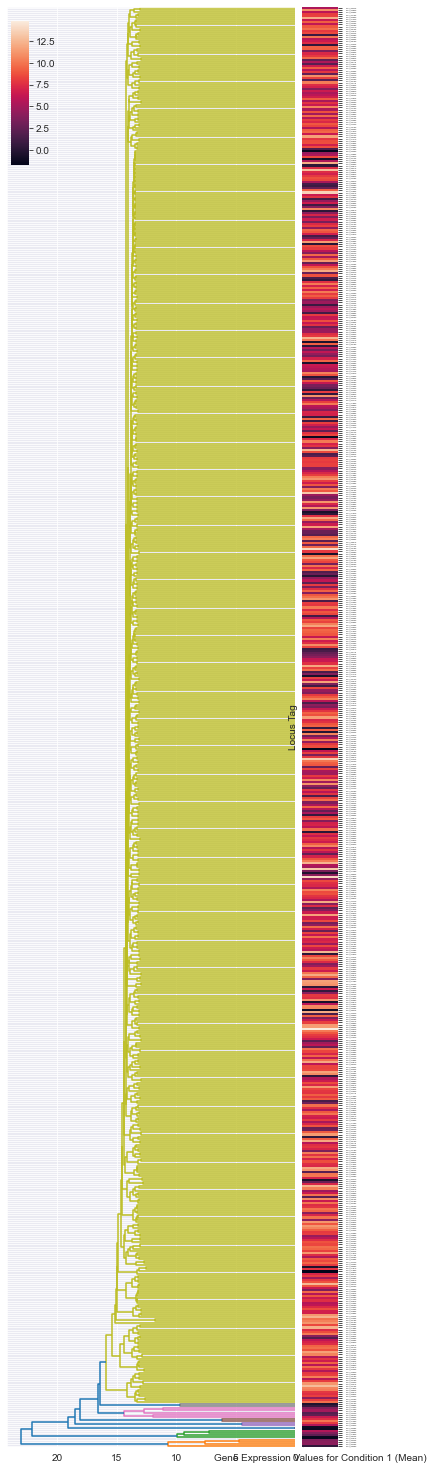

In [14]:
#Define dendogram parameters
den = plt.figure(figsize=[5, 20])
axis_1 = den.add_axes([0, 0, 0.8, 1])

#Plot dendrogram
dendrogram(average_distance, orientation="left", labels=matrix.index, leaf_font_size=1)
leaf_order = [t.get_text() for t in axis_1.get_yticklabels()]

axis_2 = den.add_axes([0.82, 0, 0.1, 1])
axis_3 = den.add_axes([0.01, 0.89, 0.05, 0.1])

#Plot the heatmap
heatmap_data = final_expression_df
heatmap_data = heatmap_data.reindex(leaf_order[::-1])

#Define heatmap parameters
sbn.heatmap(heatmap_data, yticklabels=True, ax=axis_2, cbar_ax=axis_3)
axis_2.yaxis.tick_right()
axis_2.set_yticklabels(axis_2.get_yticklabels(), rotation=0, fontsize=2)

#Save the figure
plt.savefig("dendrogram_300bp_6kmer.pdf", bbox_inches="tight")

None

## Pipeline for the Machine learning approaches
Predicting gene expression values from sequences through Extreme Gradient Boosting, Random Forest and Support Vector Machine models.

The code related to the recursive feature elimination, evaluation of the model's performance on the optimum number of features and SHAP importances was provided by Chr. Hansen.

### Definition of the training and testing set

In [15]:
#Set the model's variables
X = kmer_feature_df #features
Y = final_expression_df #target

#Split the data into training and test sets
x_train, x_test, y_train, y_test =  train_test_split(X, Y, random_state=123)

### Extreme Gradient Boosting
Extreme Gradient Boosting (XGBoost) is an open-source machine learning library designed to improve the implementation of the gradient boosting algorithm.

In [16]:
xgb_model = xgboost.XGBRegressor(eta = 0.1)
xgb_model.fit(x_train, y_train)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination  is %.3f." % xgb_model.score(x_test, y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, xgb_model.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(xgb_model.predict(x_test), y_test).correlation)

The model's accuracy is 0.017.
The mean squared error (MSE) on test set is 11.361.
The model's Spearman correlation coefficient is 0.20106912108992642.


#### Model optimization

##### Recursive feature elimination (RFE)

In [17]:
#Identify and remove features with very low feature importance (low correlation with the target) in order to increase speed
xgb_reduced_features_1 = pd.Series(xgb_model.feature_importances_, index=x_train.columns)
xgb_reduced_features_1 = xgb_reduced_features_1[xgb_reduced_features_1 >= 0.001].index

#Recursive feature elimination
xgb_rfe = RFECV(xgboost.XGBRegressor(eta = 0.1))

#Train with reduced features
xgb_rfe.fit(x_train[xgb_reduced_features_1], y_train)

#Get ranking of features
xgb_rankings = pd.Series(xgb_rfe.ranking_, index=xgb_reduced_features_1)
xgb_reduced_features_2 = xgb_rankings[xgb_rankings == 1].index
print("The number of initial features is: %s." %len(x_train.columns))
print("The number of reduced features is: %s." %len(xgb_reduced_features_2))

#Train model on reduced features
xgb_model_rfe = xgboost.XGBRegressor(eta = 0.1)
xgb_model_rfe.fit(x_train[xgb_reduced_features_2], y_train)

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(xgb_model_rfe.predict(x_test[xgb_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % xgb_model_rfe.score(x_test[xgb_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, xgb_model_rfe.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

KeyboardInterrupt: 

##### Evaluate optimum number of features for model

In [ ]:
#Calculate performances for the training set
train_performances = []


for i in range(150):
    model_train = xgboost.XGBRegressor(eta = 0.1)
    x_train_subset = x_train[xgb_rankings.sort_values()[:i+1].index]
    model_train.fit(x_train_subset, y_train)
    train_model_feature_rank = model_train.predict(x_train_subset)
    train_performances.append(stats.pearsonr(train_model_feature_rank, y_train)[0])


#Calculate performances for the testing set
test_performances = []

splitter = KFold(5, shuffle=True, random_state=2020)

for train_index, test_index in splitter.split(x_train, y_train):
    k_performances = []
    X_train_train, X_train_test = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]

    for i in range(150):
        model_test = xgboost.XGBRegressor(eta = 0.1)
        model_test.fit(X_train_train[xgb_rankings.sort_values()[:i+1].index], y_train_train)
        test_model_feature_rank = model_test.predict(X_train_test[xgb_rankings.sort_values()[:i+1].index])
        k_performances.append(stats.pearsonr(test_model_feature_rank, y_train_test)[0])
    test_performances.append(k_performances)

test_performances = np.array(test_performances, dtype=object).mean(0)

#Plot the different performances
plt.plot(range(1, 151), train_performances, label="Train")
plt.plot(range(1, 151), test_performances, label="Test")
plt.legend()
plt.xlabel("Number of features")
plt.ylabel("Pearson correlation")
plt.show()

##### Hyperparameter optimization

In [ ]:
xgb_model_hyp = xgboost.XGBRegressor(eta = 0.1)

xgb_hyper_param = {"n_estimators": stats.randint(150, 1000),
                   "learning_rate": stats.uniform(0.01, 0.59),
                   "subsample": stats.uniform(0.3, 0.6),
                   "max_depth": [3, 4, 5, 6, 7, 8, 9],
                   "colsample_bytree": stats.uniform(0.5, 0.4),
                   "min_child_weight": [1, 2, 3, 4]
                   }

xgb_param_tune = RandomizedSearchCV(xgb_model_hyp,
                         param_distributions = xgb_hyper_param,
                         cv = 5,
                         n_iter = 5,
                         scoring = "roc_auc",
                         error_score = 0,
                         verbose = 3,
                         n_jobs = -1)

xgb_param_tune.fit(x_train[xgb_reduced_features_2], y_train)

In [ ]:
xgb_param_tune.best_params_

In [ ]:
#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(xgb_param_tune.predict(x_test[xgb_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % xgb_param_tune.score(x_test[xgb_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, xgb_param_tune.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

In [ ]:
best_xgb_model = xgb_param_tune.best_estimator_
best_xgb_model

In [30]:
pickle.dump(best_xgb_model, open('model_xgb.sav', 'wb'))

### Random Forest Regression
Random Forest is an ensemble technique that uses multiple decision trees as a base learning models, combining multiple decision trees when determining the final output.

In [29]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % rf_model.score(x_test, y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, rf_model.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(rf_model.predict(x_test), y_test).correlation)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


The model's accuracy is -0.054.
The mean squared error (MSE) on test set is 10.725.


#### Model optimization

##### Recursive feature elimination (RFE)

In [33]:
#Identify and remove features with very low feature importance (low correlation with the target) in order to increase speed
rf_reduced_features_1 = pd.Series(rf_model.feature_importances_, index=x_train.columns)
rf_reduced_features_1 = rf_reduced_features_1[rf_reduced_features_1 >= 0.001].index

#Recursive feature elimination
rf_rfe = RFECV(RandomForestRegressor())

#Train with reduced features
rf_rfe.fit(x_train[rf_reduced_features_1], y_train)

#Get ranking of features
rf_rankings = pd.Series(rf_rfe.ranking_, index=rf_reduced_features_1)
rf_reduced_features_2 = rf_rankings[rf_rankings == 1].index
print("The number of initial features is: %s." % len(x_train.columns))
print("The number of reduced features is: %s." % len(rf_reduced_features_2))

#Train model on reduced features
rf_model_rfe = xgboost.XGBRegressor(eta=0.1)
rf_model_rfe.fit(x_train[rf_reduced_features_2], y_train)

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." % stats.spearmanr(
    rf_model_rfe.predict(x_test[rf_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % rf_model_rfe.score(x_test[rf_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, rf_model_rfe.predict(x_test[rf_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

The number of initial features is: 53892.
The number of reduced features is: 163.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


The model's Spearman correlation coefficient is 0.2428044980196161.
The model's accuracy is 0.059.
The mean squared error (MSE) on test set is 9.575.


##### Hyperparameter optimization

In [ ]:
rf_model_hyp = rf_model = RandomForestRegressor()

rf_hyper_param = {"bootstrap": [True, False],
                  "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  "max_features": ['auto', 'sqrt'],
                  "min_samples_leaf": [1, 2, 4],
                  "min_samples_split": [2, 5, 10],
                  "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_param_tune = RandomizedSearchCV(rf_model_hyp,
                         param_distributions = rf_hyper_param,
                         cv = 5,
                         n_iter = 5,
                         scoring = "roc_auc",
                         error_score = 0,
                         verbose = 3,
                         n_jobs = -1)

rf_param_tune.fit(x_train[rf_reduced_features_2], y_train)

In [ ]:
rf_param_tune.best_params_

In [ ]:
#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(rf_param_tune.predict(x_test[xgb_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % rf_param_tune.score(x_test[xgb_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, rf_param_tune.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

In [ ]:
best_rf_model = rf_param_tune.best_estimator_
best_rf_model

In [34]:
pickle.dump(best_rf_model, open('model_rf.sav', 'wb'))

### Support Vector Regression
Support Vector Regression is a supervised learning algorithm that is used to predict discrete values and is based on the Support Vector Machine principle.

In [18]:
svr_model = SVR()
svr_model.fit(x_train, y_train)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % svr_model.score(x_test, y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, svr_model.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(svr_model.predict(x_test), y_test).correlation)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


The model's accuracy is 0.018.
The mean squared error (MSE) on test set is 11.354.
The model's Spearman correlation coefficient is 0.2041322361115066.


#### Model optimization

##### Recursive feature elimination (RFE)

In [19]:
estimator=SVR(kernel='linear')
selector = RFECV(estimator)
selector = selector.fit(x_train, y_train)

#Get ranking of features
svr_rankings = pd.Series(selector.ranking_, index=x_train.columns)
svr_reduced_features_2 = svr_rankings[svr_rankings == 1].index
print("The number of initial features is: %s." % len(x_train.columns))
print("The number of reduced features is: %s." % len(svr_reduced_features_2))

#Train model on reduced features
svr_model_rfe = SVR()
svr_model_rfe.fit(x_train[svr_reduced_features_2], y_train)

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." % stats.spearmanr(
    svr_model_rfe.predict(x_test[svr_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % svr_model_rfe.score(x_test[svr_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, svr_model_rfe.predict(x_test[svr_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

KeyboardInterrupt: 

##### Hyperparameter optimization

In [ ]:
svr_model_hyp = SVR()

svr_hyper_param = {"C": [0.1, 1, 10, 100, 1000],
                   "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
                   "kernel": ["rbf"]}

svr_param_tune = RandomizedSearchCV(svr_model_hyp,
                         param_distributions = svr_hyper_param,
                         cv = 5,
                         n_iter = 5,
                         scoring = "roc_auc",
                         error_score = 0,
                         verbose = 3,
                         n_jobs = -1)

svr_param_tune.fit(x_train[svr_reduced_features_2], y_train)

In [ ]:
svr_param_tune.best_params_

In [ ]:
#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(svr_param_tune.predict(x_test[xgb_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % svr_param_tune.score(x_test[xgb_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, svr_param_tune.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

In [ ]:
best_svr_model = svr_param_tune.best_estimator_
best_svr_model

In [ ]:
pickle.dump(best_svr_model, open('model_svr.sav', 'wb'))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Predictions comparison

In [125]:
#Transforming the data for the predictons plots
pred_x_train = x_train.to_numpy()
pred_y_train = y_train.to_numpy()
pred_x_test = x_test.to_numpy()
pred_y_test = y_test.to_numpy()
xgb_x_train_feat = x_train[xgb_reduced_features_2].to_numpy()
xgb_x_test_feat = x_test[xgb_reduced_features_2].to_numpy()
rf_x_train_feat = x_train[rf_reduced_features_2].to_numpy()
rf_x_test_feat = x_test[rf_reduced_features_2].to_numpy()
svr_x_train_feat = x_train[svr_reduced_features_2].to_numpy()
svr_x_test_feat = x_test[svr_reduced_features_2].to_numpy()

#### Extreme Gradient Boosting

SpearmanrResult(correlation=0.2205207812208018, pvalue=0.003455807864393107)


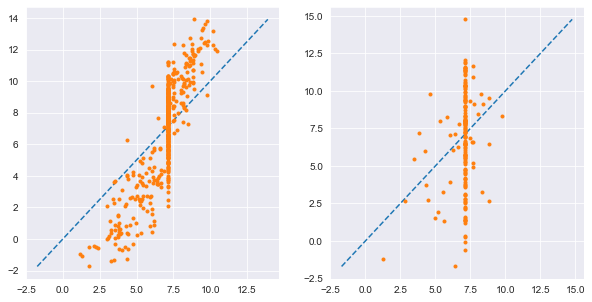

In [82]:
#Compare the predictions and measurements by plot and the spearman correlation coefficient
plt.figure(figsize=[10, 5])

#Plot for the training set
plt.subplot(1, 2, 1)
plt.plot([pred_y_train.min(), pred_y_train.max()], [pred_y_train.min(), pred_y_train.max()], "--")
plt.plot(best_xgb_model.predict(xgb_x_train_feat), pred_y_train, ".")

#Plot for the testing set
plt.subplot(1, 2, 2)
plt.plot([pred_y_test.min(), pred_y_test.max()], [pred_y_test.min(), pred_y_test.max()], "--")
plt.plot(best_xgb_model.predict(xgb_x_test_feat), pred_y_test, ".")

print(stats.spearmanr(best_xgb_model.predict(xgb_x_test_feat), pred_y_test))

#### Random Forest Regression

SpearmanrResult(correlation=0.2428044980196161, pvalue=0.0012458359829320392)


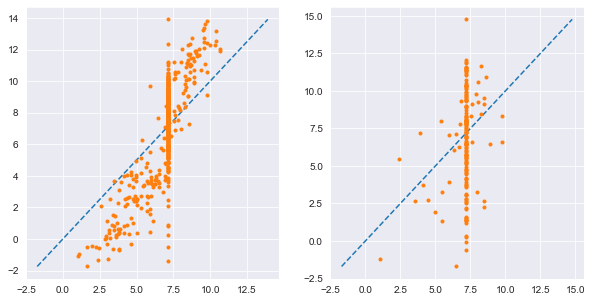

In [83]:
#Compare the predictions and measurements by plot and the spearman correlation coefficient
plt.figure(figsize=[10, 5])

#Plot for the training set
plt.subplot(1, 2, 1)
plt.plot([pred_y_train.min(), pred_y_train.max()], [pred_y_train.min(), pred_y_train.max()], "--")
plt.plot(best_rf_model.predict(rf_x_train_feat), pred_y_train, ".")

#Plot for the testing set
plt.subplot(1, 2, 2)
plt.plot([pred_y_test.min(), pred_y_test.max()], [pred_y_test.min(), pred_y_test.max()], "--")
plt.plot(best_rf_model.predict(rf_x_test_feat), pred_y_test, ".")

print(stats.spearmanr(best_rf_model.predict(rf_x_test_feat), pred_y_test))

#### Support Vector Regression

X does not have valid feature names, but SVR was fitted with feature names


ValueError: x and y must have same first dimension, but have shapes (1,) and (174, 1)

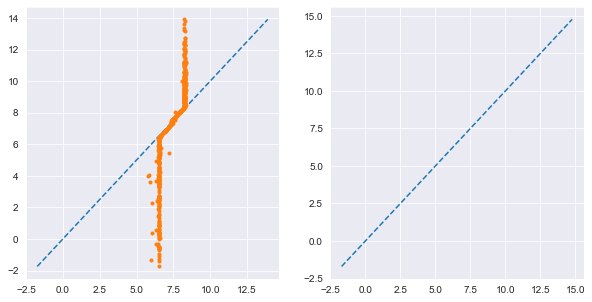

In [124]:
#Compare the predictions and measurements by plot and the spearman correlation coefficient
plt.figure(figsize=[10, 5])

#Plot for the training set
plt.subplot(1, 2, 1)
plt.plot([pred_y_train.min(), pred_y_train.max()], [pred_y_train.min(), pred_y_train.max()], "--")
plt.plot(best_svr_model.predict(svr_x_train_feat), pred_y_train, ".")

#Plot for the testing set
plt.subplot(1, 2, 2)
plt.plot([pred_y_test.min(), pred_y_test.max()], [pred_y_test.min(), pred_y_test.max()], "--")
plt.plot(best_svr_model.predict(svr_x_test_feat), pred_y_test, ".")

print(stats.spearmanr(best_svr_model.predict(svr_x_test_feat), pred_y_test))

### SHAP Importances

In [84]:
def shap_importances(x,
                     trained_model,
                     n_features=30,
                     plot=None,
                     n_non_genetic_features=0,
                     tax_dict=None):
    """
    ONLY for tree models!
    Gets the most important features, as identified by Shap and makes Shap
    feature importance plots.
    Learn more about Shap: https://github.com/slundberg/shap
    If the plot list contains 'summary', a Shap summary plot will be made.
    If the plot list contains any strain IDs (from the index of X), the
    function also makes individual Shap plots for each prediction for those
    strain IDs. All plots are returned in a dictionary.

    Input:
    -------
    x: Pandas DataFrame.
        Strain IDs in index, features in the columns.
    trained_model: Trained scikit learn tree model.
    n_features: Integer (default=30).
        Number of the highest importance features to plot and return.
    plot: List (default=[]).
        Can contain the values 'summary' and IDs from X.index.
        If the list is empty, no plots are made.
        If it contains 'summary' it makes Shap feature importance plot.
        If it contains IDs from X.index it makes Shap plots for each sample.
    n_non_genetic_features: Integer (default=0).
        Number of non-genetic features. This is used for names and labels in
        the individual sample plots.
    tax_dict: Dictionary.
        Strain IDs as keys and taxonomy values. This is used for labels in
        the individual sample plots.

    Returns:
    --------
    top_features: List of strings.
        List of the highest importance features (corresponding to the plot).
        Only returns the n_features top features.
    figures: Dictionary.
        Dictionary of Shap plots. Plot names as keys, plots as values.
        The plot names are either 'summary' or they start with a strain ID
        and contain information on the contition values of the sample.
        Print the dictionary keys to see: print(figures.keys())
    """

    if plot is None:
        plot = []
    for p in plot:
        if p not in ['summary'] + list(x.index):
            raise Exception('"plot" contains invalid values.')

    # Explain the model's predictions with SHAP values:
    model_explainer = shap.TreeExplainer(trained_model)
    shap_values = model_explainer.shap_values(x)

    figures = {}

    if 'summary' in plot:
        fig_2 = plt.figure()
        # Plot the effects of the features:
        shap.summary_plot(shap_values, x, max_display=n_features, show=False)
        figures['summary'] = fig_2

    # Get numeric index of which rows (samples) of X to plot:
    rows = [row for row in range(len(x)) if x.index[row] in plot]

    # Plot the effects of the features for each individual prediction:
    for i in rows:
        fig_2 = shap.force_plot(model_explainer.expected_value,
                              shap_values[i, :],
                              x.iloc[i, :],
                              matplotlib=True,
                              show=False)  # If show=True fig is empty
        if n_non_genetic_features > 0:
            # Put label on x-axis to know which sample it is:
            # X.index[i] is the strain ID
            # tax_dict[X.index[i]] is the taxonomy
            # X.columns is the feature list
            plt.xlabel(x.index[i] + ', ' + tax_dict[x.index[i]] + ', ' +
                       ', '.join([x.columns[j] + '=' + str(x.iloc[i, j])
                                  for j in range(n_non_genetic_features)]))
            name = x.index[i] + '__'
            name += '__'.join([x.columns[j] + '_' + str(x.iloc[i, j])
                               for j in range(n_non_genetic_features)])
            figures[name] = fig_2
        else:
            # Put label on x-axis to know which sample it is:
            plt.xlabel(x.index[i] + ', ' + tax_dict[x.index[i]])
            figures[x.index[i]] = fig_2

    top_features = x.columns[np.argsort(np.abs(shap_values).mean(0))[::-1]]
    top_features = list(top_features)[:n_features]

    return top_features, figures

#### Extreme Gradient Boosting

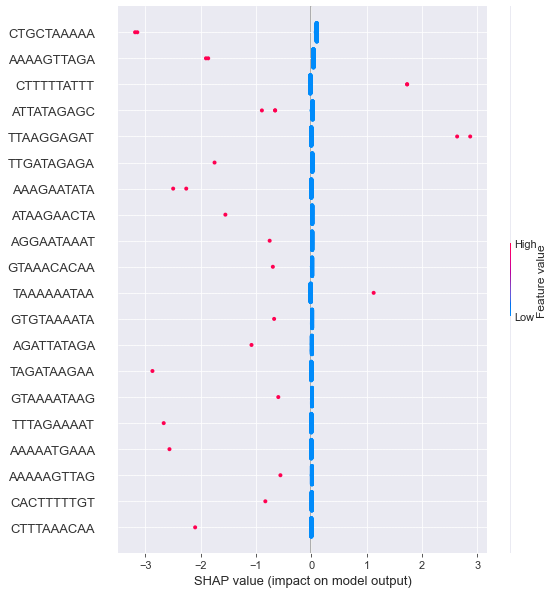

In [120]:
shap.initjs()

xgb_model_explainer = shap.TreeExplainer(best_xgb_model, x_test[xgb_reduced_features_2])
xgb_shap_values = xgb_model_explainer.shap_values(x_test[xgb_reduced_features_2])

xgb_fig = plt.figure()
xgb_ax = xgb_fig.add_axes([0, 0, 0.8, 0.8])
shap.summary_plot(xgb_shap_values, x_test[xgb_reduced_features_2])
plt.savefig("shap_summary_xgb.pdf")
plt.close()

#### Random Forest Regression

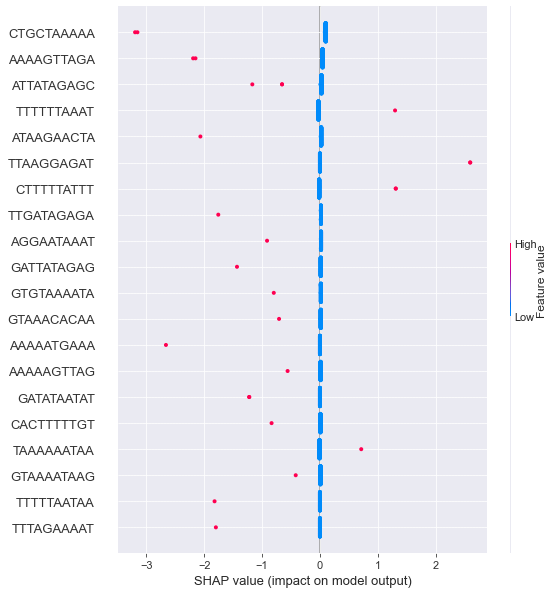

In [121]:
shap.initjs()

rf_model_explainer = shap.TreeExplainer(best_rf_model, x_test[rf_reduced_features_2])
rf_shap_values = rf_model_explainer.shap_values(x_test[rf_reduced_features_2])

rf_fig = plt.figure()
rf_ax = rf_fig.add_axes([0, 0, 0.8, 0.8])
shap.summary_plot(rf_shap_values, x_test[rf_reduced_features_2])
plt.savefig("shap_summary_rf.pdf")
plt.close()

#### Support Vector Regression

In [ ]:
shap.initjs()

svr_model_explainer = shap.TreeExplainer(best_svr_model, x_test[svr_reduced_features_2])
svr_shap_values = svr_model_explainer.shap_values(x_test[svr_reduced_features_2])

svr_fig = plt.figure()
svr_ax = svr_fig.add_axes([0, 0, 0.8, 0.8])
shap.summary_plot(svr_shap_values, x_test[svr_reduced_features_2])
plt.savefig("shap_summary_svr.pdf")
plt.close()